In [29]:
import idx2numpy
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# The MNISTDataset class is a custom dataset implementation inheriting from PyTorch's Dataset class.
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

# The Accumulator class is a utility to maintain a running total of multiple metrics or values.
# It simplifies operations like summing over batches in training loops.
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# The Animator class provides a flexible tool for real-time plotting and visualization during model training.
# It allows users to track and display metrics.
# In the training, we display Cross Entropy Loss during training, training accuracy, and test accuracy
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5.5, 4.5)):
        if legend is None:
            legend = []
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [31]:
# Displays a grid of images with optional titles.
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])

# Configures the appearance of a plot's axes.
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Converts numerical labels into their corresponding text labels.
# Returns:
# - The accuracy as a float value.
def get_labels(labels):
    text_labels = ['0', '1', '2', '3', '4', 
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# Calculates the accuracy of predictions compared to ground truth labels.
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# Evaluates the accuracy of a model on a dataset.
# Returns:
# - The accuracy of the model as a float value.
def evaluate_accuracy(net, data_iter):
    net.eval()
    net.to(device)
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [32]:
# The FNN (Fully Connected Neural Network) class implements a simple feedforward neural network
# for classification tasks. It uses three fully connected layers with ReLU activations and 
# dropout for regularization.
# - The input layer takes in 28x28 images (flattened to a vector of size 784).
# - Two hidden layers: the first with 128 units and the second with 64 units.
# - The output layer has 10 units corresponding to 10 classes.
# Dropout layers are used with a probability of 0.2 to help prevent overfitting.
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.Linear(28 * 28, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(64, 10))
    
    def forward(self, x):
        x = self.net(x)
        return x

# A revised version of LeNet class for image classification tasks.
# It is designed for images like MNIST (28x28 grayscale images) and includes:
# - Two convolutional layers followed by max-pooling operations.
# - Two fully connected layers after flattening the output of the final convolutional layer.
# The model also uses ReLU activations to introduce non-linearity between layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(6, 16, kernel_size=5),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Flatten(),
                                 nn.Linear(16 * 5 * 5, 120),
                                 nn.ReLU(),
                                 nn.Linear(120, 84),
                                 nn.ReLU(),
                                 nn.Linear(84, 10))
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.net(x)
        return x


In [33]:
# The train_epoch function performs one full pass through the training data for a single epoch.
# It computes the loss, performs backpropagation, and updates the model's weights.
# Returns:
# - Average training loss and accuracy for the epoch.
def train_epoch(net, train_iter, loss, updater):
    net.train()
    net.to(device)
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

# The train function runs the training loop for the specified number of epochs.
# It tracks both training and test accuracy while also visualizing the metrics with Animator.
# Returns:
# - The final test accuracy after training.
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0], 
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    print(f"Cross Entropy Loss is {train_loss}")
    print(f"Train Accuracy is {train_acc}")
    print(f"Test Accuracy is {test_acc}")
    print('--------------------------------------------')
    
    return test_acc

In [34]:
# Load the training and testing data from IDX file format and convert them to PyTorch tensors.
train_data = torch.tensor(idx2numpy.convert_from_file('./Data/train-images.idx3-ubyte'), dtype=torch.float32)
train_labels = torch.tensor(idx2numpy.convert_from_file('./Data/train-labels.idx1-ubyte'), dtype=torch.long)
test_data = torch.tensor(idx2numpy.convert_from_file('./Data/t10k-images.idx3-ubyte'), dtype=torch.float32)
test_labels = torch.tensor(idx2numpy.convert_from_file('./Data/t10k-labels.idx1-ubyte'), dtype=torch.long)

# Create custom MNIST dataset objects using the loaded image and label tensors
train_dataset = MNISTDataset(train_data, train_labels)
test_dataset = MNISTDataset(test_data, test_labels)

# Create data loaders for both the training and testing datasets, specifying batch size and shuffle settings.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### **We can have a brief look of the data**
- Above numbers are their true labels

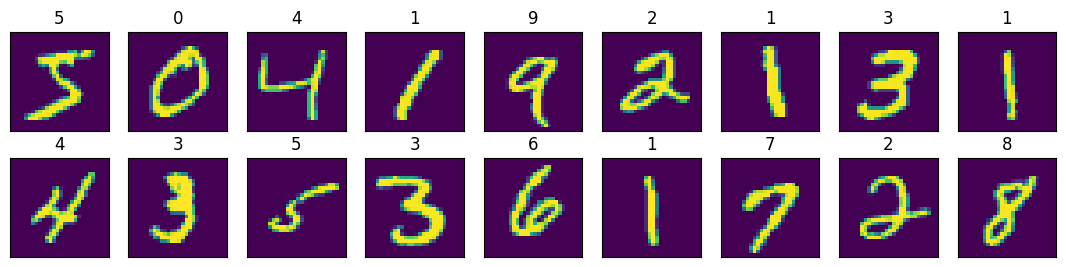

In [35]:
X, y = next(iter(DataLoader(train_dataset, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_labels(y))

# **Part 1: FNN**
### Now we train 5 FNN models, each train 5 epoches.
- Cross Entropy Loss is chosen for classification problem.
- Adam optimizer is chosen, with learning rate $0.001$.
- The train loss, train accuracy, and test accuracy for each model at each epoch is shown in the animation
- We can see the model converges very fast.

Cross Entropy Loss is 0.0028938358983102565
Train Accuracy is 0.9471
Test Accuracy is 0.9627
--------------------------------------------


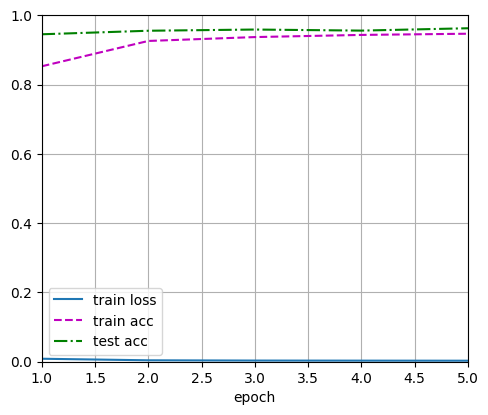

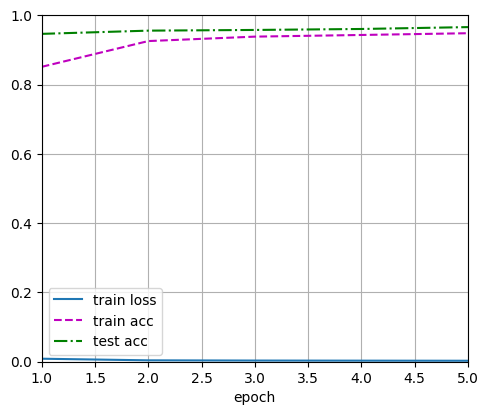

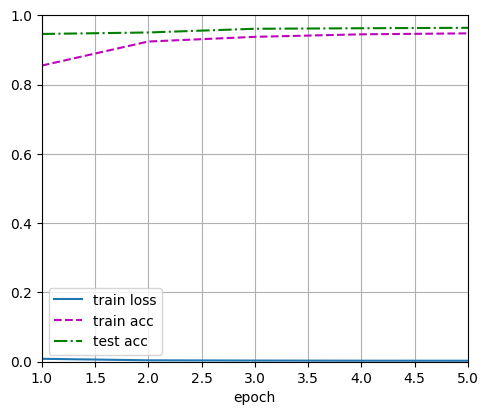

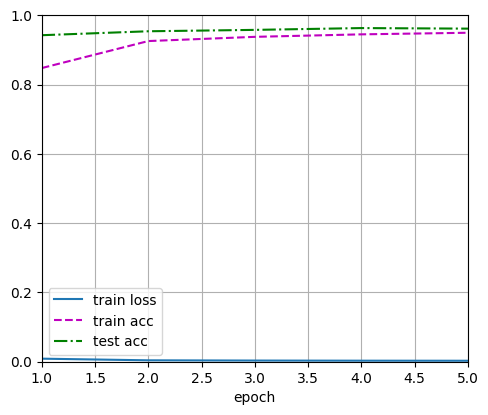

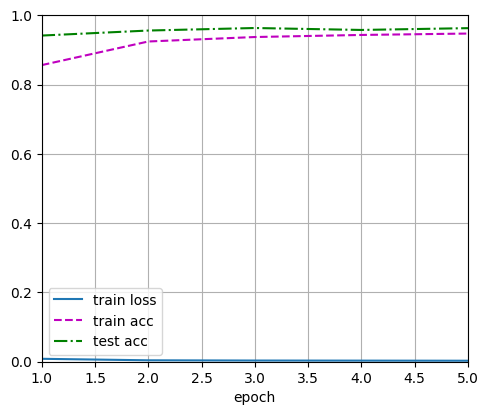

In [36]:
FNN_Acc = []
for i in range(5):
    print(f"The {i + 1}th runs of FNN model")
    model = FNN()
    loss = nn.CrossEntropyLoss()
    updater = optim.Adam(model.parameters(), lr=1e-3)

    acc =  train(model, train_loader, test_loader, loss, 5, updater)
    FNN_Acc.append(acc)

# **FNN Result**

We train the model 5 times, with an average accuracy in test set **96.5%**

**Lessons:**
1. We need to be careful about choosing the right number of neurons of each layer, to ensure the data passing correct
2. Relu Activation is faster than sigmoid with similar accuracy. It has a easier derivative.
3. Regularization like dropout is useful for preventing overfit.

In [37]:
mean = sum(FNN_Acc) / len(FNN_Acc)
print(f"FNN model has accuracy {mean}")

FNN model has accuracy 0.96316


## We can have a look of the performance
We predict 32 graph using the model we trained, and display them. The predicted label is above each graph. 

The performance looks good

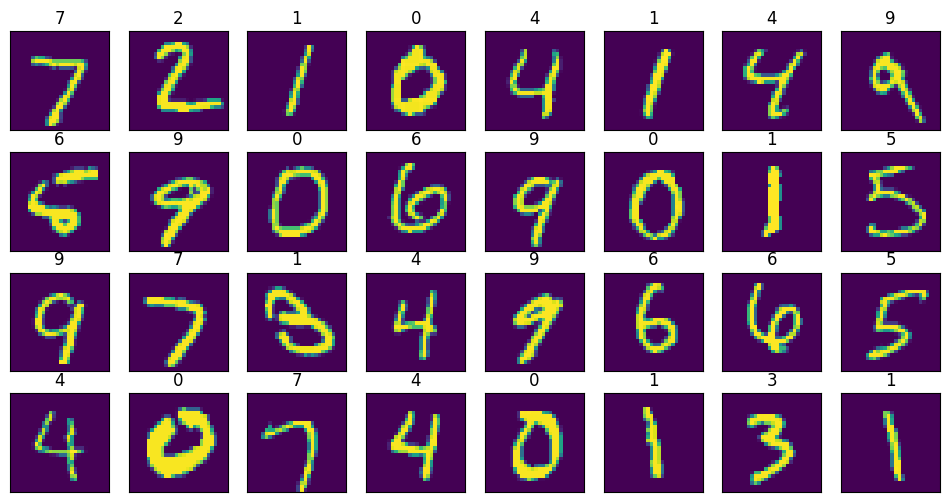

In [38]:
X, _ = next(iter(DataLoader(test_dataset, batch_size=32)))
model.to('cpu')
y_hat = model(X).argmax(axis=1)
show_images(X.reshape(32, 28, 28), 4, 8, titles=get_labels(y_hat))

# **Part 2: CNN**
### Now we train 5 CNN models, each train 5 epoches.
- Cross Entropy Loss is chosen for classification problem.
- Adam optimizer is chosen, with learning rate $0.001$.
- The train loss, train accuracy, and test accuracy for each model at each epoch is shown in the animation
- The model also converges very fast.

Cross Entropy Loss is 0.000481506065927897
Train Accuracy is 0.99035
Test Accuracy is 0.984
--------------------------------------------


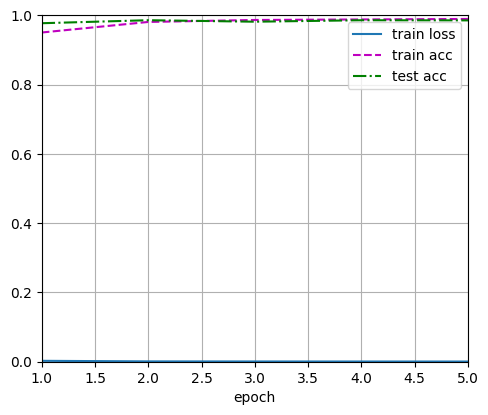

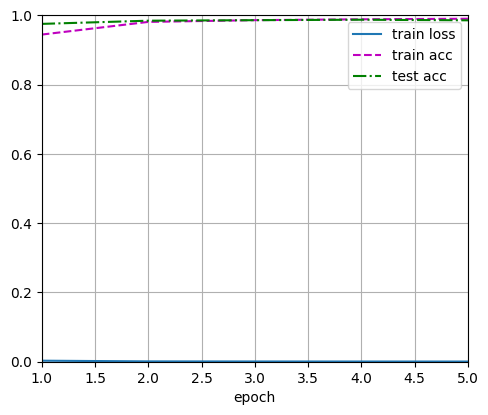

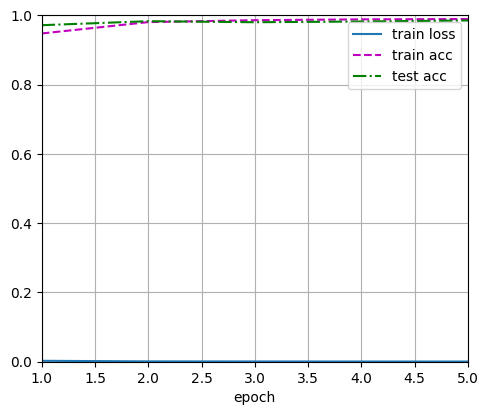

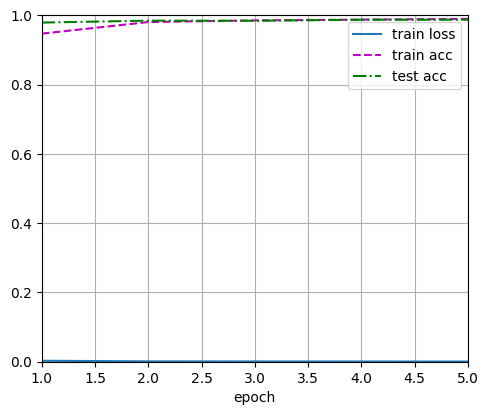

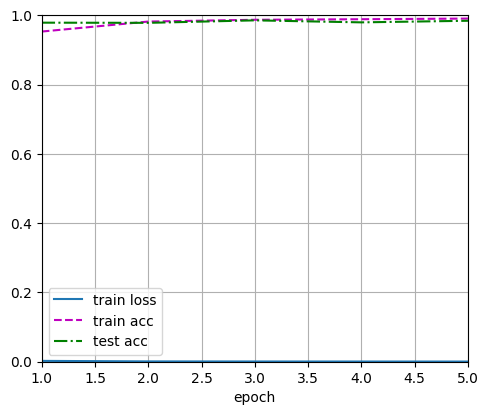

In [39]:
CNN_Acc = []
for i in range(5):
    print(f"The {i + 1}th runs of RNN model")
    model = LeNet()
    loss = nn.CrossEntropyLoss()
    updater = optim.Adam(model.parameters(), lr=1e-3)

    acc =  train(model, train_loader, test_loader, loss, 5, updater)
    CNN_Acc.append(acc)

# **CNN Result**

We train the model 5 times, with an average accuracy in test set **98.5%**

**Lessons:**
1. CNN performs better than FNN, for that it considers features in 2D dimension
2. The original paper "Gradient-based learning applied to document recognition" used Average Pooling, I revise the model by using Max Pooling. It has a better performance because Max Pooling retains the strongest activations in a pooling region, which are often associated with the most important or obvious features in the input.

In [40]:
mean = sum(CNN_Acc) / len(CNN_Acc)
print(f"CNN model has accuracy {mean}")

CNN model has accuracy 0.9852399999999999


## We can also have a look of the performance
We predict 32 graph using the model we trained, and display them. The predicted label is above each graph. 

The performance looks good

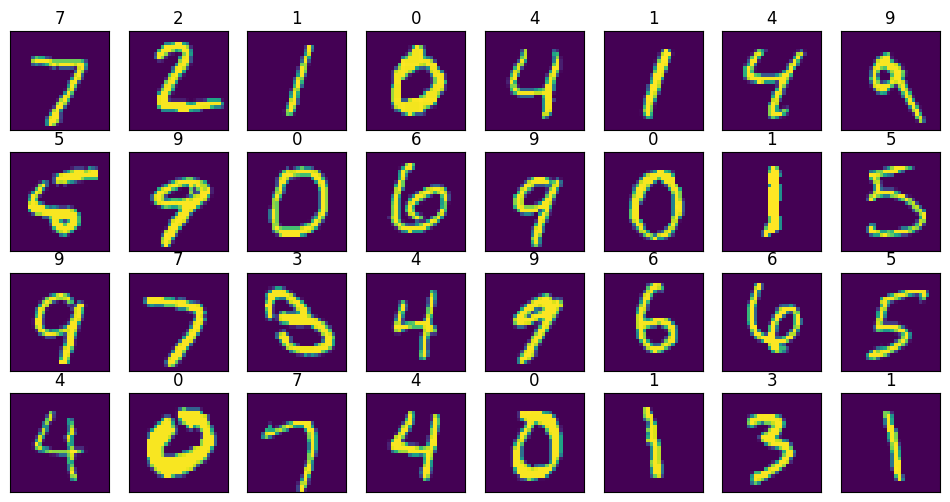

In [41]:
X, _ = next(iter(DataLoader(test_dataset, batch_size=32)))
model.to('cpu')
y_hat = model(X).argmax(axis=1)
show_images(X.reshape(32, 28, 28), 4, 8, titles=get_labels(y_hat))